In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)
input_steps = 6   
output_steps = 6  


In [13]:
import pandas as pd
data_file = "data_readed.xlsx"
df = pd.read_excel(data_file)
df.head()


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0,104,2020-10-01 00:00:00,0.0,197.25,61.953484,-113.054688,-0.000017,0.676296,36.621414,...,-59037,0.023543,-27549,0.373413,59.393524,59.004852,-5.800369,-0.907883,-0.157303,3.689789
1,0,104,2020-10-01 01:00:00,0.0,138.50,9999.000000,-128.285156,-0.000038,0.676296,36.078514,...,-203202,0.023543,-64968,0.274780,59.516571,59.215790,-5.511688,-0.485977,-0.572311,3.517319
2,0,104,2020-10-01 02:00:00,0.0,102.00,9999.000000,-120.671875,-0.000055,0.676296,35.410492,...,-376145,0.023543,-81566,0.194763,59.715759,59.483337,-4.963364,-0.448380,-1.284912,3.182495
3,0,104,2020-10-01 03:00:00,0.0,160.75,9999.000000,-169.191406,-0.000064,0.676296,34.843140,...,-609080,0.023543,-101141,0.187439,60.249374,60.005234,-4.379272,-0.892761,-2.056778,2.465332
4,0,104,2020-10-01 04:00:00,0.0,204.50,213.468903,-304.347656,-0.000112,0.676296,34.893394,...,-654851,0.023543,-97831,0.104156,60.974991,60.775604,-3.959961,-1.550842,-2.280151,1.559830


In [ ]:
features = df.columns[3:13].tolist()  # 10 features làm đầu vào
target_label = 'AWS'

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime').reset_index(drop=True)

df[features] = df[features].fillna(method='ffill')

# Chuẩn hóa z-score chỉ cho các features đầu vào
for col in features:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val

print(df[features + [target_label]].head())


C:\Users\giakh\AppData\Local\Temp\ipykernel_24612\289055846.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features] = df[features].fillna(method='ffill')


        AWS      CAPE       CIN      EWSS        IE      ISOR        KX  \
0 -0.161120 -0.109219 -1.064815  0.045037  0.335245 -0.107804  0.388789   
1 -0.161120 -0.109219 -1.064815  0.045037  0.335245 -0.107804  0.388789   
2 -0.161120  0.322181 -1.090568  0.288091  0.559374  1.853284  0.504035   
3 -0.116847 -0.307126 -1.061512 -0.303887  0.559687 -2.484729  0.452349   
4 -0.161120 -0.077759 -1.064151 -0.347130  0.185617 -0.234783  0.567362   

        PEV      R250      R500       AWS  
0  0.519992 -1.118058  0.522752 -0.161120  
1  0.519992 -1.118058  0.522752 -0.161120  
2  0.578234 -1.154437 -1.447154 -0.161120  
3  0.585981 -1.211939 -0.360003 -0.116847  
4  0.452856 -0.929514  0.769719 -0.161120  


In [15]:
def create_dataset(df, features, target_label, past=6, future=6):
    X, y = [], []
    feature_values = df[features].values
    target_values = df[target_label].values
    
    for i in range(len(df) - past - future + 1):
        X.append(feature_values[i:(i + past)])
        y.append(target_values[i + past:i + past + future])
        
    return np.array(X), np.array(y)

input_steps = 6
output_steps = 6

X, y = create_dataset(df, features, target_label, input_steps, output_steps)
print(X.shape, y.shape)


(657670, 6, 10) (657670, 6)


In [16]:

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [17]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(output_steps))
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,590 (76.52 KB)

 Trainable params: 19,590 (76.52 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
model.save('rain_prediction_model_v2.h5')


Epoch 1/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.5815 - val_loss: 0.6080
Epoch 2/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.5753 - val_loss: 0.6091
Epoch 3/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5733 - val_loss: 0.6124
Epoch 4/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.5717 - val_loss: 0.6193
Epoch 5/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.5701 - val_loss: 0.6255
Epoch 6/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.5688 - val_loss: 0.6193
Epoch 7/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5667 - val_loss: 0.6131
Epoch 8/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5646 - val_loss: 0.6143
Epoch 9/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5632 - val_loss: 0.6150
Epoch 10/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5610 - val_loss: 0.6151
Epoch 11/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.5594 - val_loss: 0.6166
Epoch 12

In [19]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
r2 = r2_score(y_test.flatten(), y_pred.flatten())

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


4111/4111 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Mean Squared Error (MSE): 2.9782517261379593
Mean Absolute Error (MAE): 0.5634814380310567
R-squared (R2): -0.16562418580994387


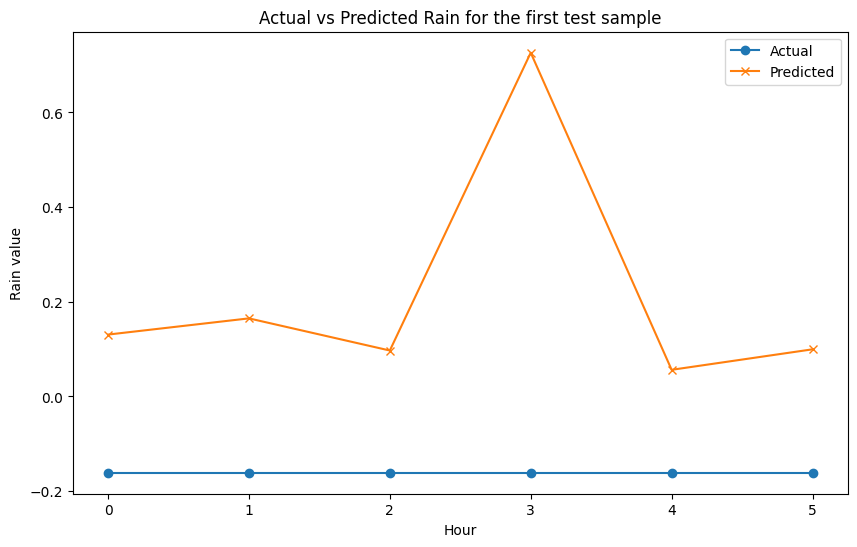

In [20]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred[0], marker='x', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample')
plt.legend()
plt.show()
